In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

from sklearn.preprocessing import StandardScaler

In [88]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

#### 기본적인 열연, 철강석, 유연탄, PMI 데이터 불러온 과정

In [89]:
file_path = '지표.xlsx'

# Excel 파일 불러오기
df = pd.read_excel(file_path)
df.set_index('날짜', inplace = True)

usedf = pd.DataFrame()
usedf['스프레드'] = df['스프레드']
usedf['pmi'] = df['pmi']
usedf['유연탄가격'] = df['유연탄가격']
usedf['열연선물가격'] = df['열연선물가격']

#### 기본적인 데이터 불러오기 및 정리가 끝났고 이제 이들을 하나로 합친 지수 그래프 따로 만들 단계 !!

In [90]:
# StandardScaler 객체를 생성합니다.
scaler = StandardScaler()

# 각 데이터프레임의 'value' 열을 표준화합니다.
usedf_scaled = scaler.fit_transform(usedf)
usedf_scaled = pd.DataFrame(usedf_scaled, columns = usedf.columns, index=usedf.index)

In [6]:
!pip install finance-datareader

^C


### 여기서부터 종목 주가 정보 받아오는 단계입니다

In [91]:
import FinanceDataReader as fdr

# 포스코의 종목 코드는 '005490'
posco = fdr.DataReader('005490', '2013-02-01', '2023-09-29')
hyundai = fdr.DataReader('004020', '2013-02-01', '2023-09-29') 
dongkuk = fdr.DataReader('001230', '2013-02-01', '2023-09-29')

#----------지수정보와 주가를 합치는 이유는 이후에 주가이평선 전용 수익을 따로 구할려고-------------

stock_merged_posco = posco.join(usedf_scaled, how='left')
stock_merged_hyundai = hyundai.join(usedf_scaled, how = 'left')
stock_merged_dongkuk = dongkuk.join(usedf_scaled, how = 'left')

stock_merged_posco = merged_posco.fillna(method='ffill')
stock_merged_hyundai = hyundai.fillna(method='ffill')
stock_merged_dongkuk = stock_merged_dongkuk.fillna(method='ffill')

#-----------그냥 그런갑다 하고 넘어가주시면 됩니다. 계수 grid 코드 뒤에 나오는 부분이에요 ---------

# ----------- 계수 grid 구할 때 합치는 merged와 차이를 두기 위해 stock을 붙임 ----------------


# 'Date' 열을 datetime 타입으로 변환


### 자산 축적 흐름 추적 함수입니다

In [92]:
def asset_final (df):
    asset = 0
    asset_list = []

    # 매수 상태를 나타내는 변수 (매수하면 True, 매도하면 False)
    buy_flag = False

    # 매수한 가격을 저장하는 변수
    buy_price = 0

    # 데이터프레임의 각 행을 순회하면서 매수/매도 신호에 따라 작업을 수행
    for i, row in df.iterrows():
        # 매수 신호가 나왔고, 아직 매수하지 않은 상태라면 매수를 진행
        if row['signal'] == 1.0 and not buy_flag:
            buy_flag = True
            buy_price = row['Close']
            asset_list.append(asset_list[-1])  # 매수 직후에는 변화 없음

        # 매도 신호가 나왔고, 매수한 상태라면 매도를 진행
        elif row['signal'] == 0.0 and buy_flag:
            buy_flag = False
            # 매도 종가 - 매수 종가로 가격 차이를 계산
            net_profit = row['Close'] - buy_price
            asset = asset_list[-1] + net_profit
            asset_list.append(asset)
            

        # 매수 상태면서 매도 신호가 아직 오지 않았다면, 가격 변화를 계산해서 추가
        elif buy_flag and row['signal'] != 0.0:
            asset_list.append(asset)

        # 매수 상태가 아니라면 가격 변화가 없으므로 이전 값을 그대로 사용
        else:
            asset_list.append(asset_list[-1] if asset_list else 0)
            
    # 가격 변화를 데이터프레임에 추가
    
    
    return asset_list[-1]

### (현대제철과 포스코 반영) 최적의 지수 가중치 구하는 단계... 여기서 최대한 다양한 스콥으로 가중치 돌려보면서 가장 자산축적이 많이 이뤄지는 가중치 경우의 수를 찾아주셨으면 좋겠습니다

In [ ]:
df_index = pd.DataFrame(index=usedf.index)

c_1 = []
c_2 = []
c_3 = []
c_4 = []

posco_asset = []
hyundai_asset = []
dongkuk_asset = []
## 현금흐름 저장하는 list 생성
final_asset_list = []

start = -3
end = 6
for c1 in tqdm(range(start, end)) :                      # 스프레드
    for c2 in range(start, end) :                  # 중국 PMI
        for c3 in range(start, end) :              # 유연탄 가격
            for c4 in range(start, end) :          # 열연 가격
                L2 = math.sqrt(c1*c1 + c2*c2 + c3*c3 + c4*c4)  # L2 정규화
                if L2 != 0 :
                    df_index['index'] = c1 * usedf_scaled[usedf.columns[0]] + c2 * usedf_scaled[usedf.columns[1]] + c3 * usedf_scaled[usedf.columns[2]] + c4 * usedf_scaled[usedf.columns[3]]
                    df_index['index_moving_short_avg'] = df_index['index'].rolling(window=1, min_periods=1).mean()
                    df_index['index_moving_long_avg'] = df_index['index'].rolling(window=500, min_periods=1).mean()
                    df_index['signal'] = np.where(df_index['index_moving_short_avg'] > df_index['index_moving_long_avg'], 1.0, 0.0)
            
                    merged_posco = posco.join(df_index, how='left')
                    merged_hyundai = hyundai.join(df_index, how = 'left')
                    merged_dongkuk = dongkuk.join(df_index, how = 'left') # 동국제강도 국내 철강회사 3위래서 일단 넣어봣습니다

                    merged_posco_a = merged_posco.fillna(method='ffill')
                    merged_hyundai_a = merged_hyundai.fillna(method='ffill')
                    merged_dongkuk_a = merged_dongkuk.fillna(method='ffill') # (포스코, 현대), (포스코, 현대, 동국) 두가지 경우 비교해서 계수 구해주시면 감사하겠습니다
                    
                    c_1.append(c1 / L2)
                    c_2.append(c2 / L2)
                    c_3.append(c3 / L2)
                    c_4.append(c4 / L2)
                    
                    solution = asset_final(merged_posco_a) + asset_final(merged_hyundai_a) + asset_final(merged_dongkuk_a)
                    
                    posco_asset.append(asset_final(merged_posco_a))
                    hyundai_asset.append(asset_final(merged_hyundai_a))
                    dongkuk_asset.append(asset_final(merged_dongkuk_a))
                    
                    final_asset_list.append(solution)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

### 아래 코드는 지수그래프가 아니라 일반 주가 이평선을 사용했을 때의 자산 축적

### 아래의 주가 이평선 기준으로 했을 때 asset_final이 적게 나오면 우리의 가설이 설득력이 높아집니다
### 주가 이평선은 200일(10달), 500일(2년) 등등 여러개가 있을 수 있는데 이것도 여러분이 여러개 실험해보면서 값의 추이를 보시면 좋겠습니다

In [57]:
# ------ 포스코 500일 장기이평선 기준 ------

basic_calcu_p = pd.DataFrame(index=stock_merged_posco.index)
basic_calcu_p['moving_avg'] = stock_merged_posco['Close'].rolling(window = 500, min_periods = 1).mean()
basic_calcu_p['Close'] = stock_merged_posco['Close']
basic_calcu_p['signal'] = np.where(basic_calcu_p['Close']> basic_calcu_p['moving_avg'], 1.0, 0.0)
asset_final(basic_calcu_p)

-14000.0

In [79]:
# ------ 포스코 200일 장기이평선 기준 ------

basic_calcu_p = pd.DataFrame(index=stock_merged_posco.index)
basic_calcu_p['moving_avg'] = stock_merged_posco['Close'].rolling(window = 200, min_periods = 1).mean()
basic_calcu_p['Close'] = stock_merged_posco['Close']
basic_calcu_p['signal'] = np.where(basic_calcu_p['Close']> basic_calcu_p['moving_avg'], 1.0, 0.0)
asset_final(basic_calcu_p)

In [60]:
# ------ 현대 500일 장기이평선 기준 ------

basic_calcu_h = pd.DataFrame(index=stock_merged_hyundai.index)
basic_calcu_h['moving_avg'] = stock_merged_hyundai['Close'].rolling(window = 500, min_periods = 1).mean()
basic_calcu_h['Close'] = stock_merged_hyundai['Close']
basic_calcu_h['signal'] = np.where(basic_calcu_h['Close']> basic_calcu_h['moving_avg'], 1.0, 0.0)
asset_final(basic_calcu_h)

-47300.0

In [61]:
# ------ 현대 200일 장기이평선 기준 ------

basic_calcu_h = pd.DataFrame(index=stock_merged_hyundai.index)
basic_calcu_h['moving_avg'] = stock_merged_hyundai['Close'].rolling(window = 200, min_periods = 1).mean()
basic_calcu_h['Close'] = stock_merged_hyundai['Close']
basic_calcu_h['signal'] = np.where(basic_calcu_h['Close']> basic_calcu_h['moving_avg'], 1.0, 0.0)
asset_final(basic_calcu_h)

-45350.0

### 최적 가중치 계수 구하는 단계

In [37]:
df_final = pd.DataFrame()
df_final['c1'] = c_1
df_final['c2'] = c_2
df_final['c3'] = c_3
df_final['c4'] = c_4
df_final['finalasset'] = final_asset_list

In [38]:
df_final_max = df_final[df_final['finalasset'] == max(df_final['finalasset'])]

In [39]:
df_final_max

,c1,c2,c3,c4,finalasset
3576,0.179605,0.898027,-0.359211,0.179605,544350.0


# 최댓값 분석

In [63]:
df_index = pd.DataFrame(index=usedf.index)

c1 = 0.179605
c2 = 0.898027
c3 = -0.359211
c4 = 0.179605

df_index['index'] = c1 * usedf_scaled[usedf.columns[0]] + c2 * usedf_scaled[usedf.columns[1]] + c3 * usedf_scaled[usedf.columns[2]] + c4 * usedf_scaled[usedf.columns[3]]

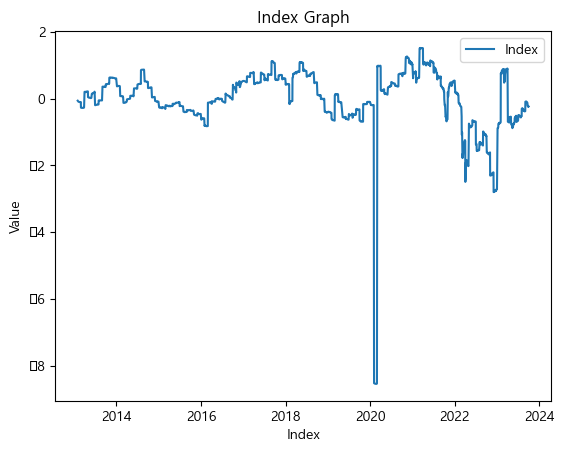

In [64]:
plt.plot(df_index.index, df_index['index'], label='Index')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Index Graph')
plt.legend()
plt.show()

In [66]:
df_index['index_moving_short_avg'] = df_index['index'].rolling(window=1, min_periods=1).mean()
df_index['index_moving_long_avg'] = df_index['index'].rolling(window=500, min_periods=1).mean()
df_index['signal'] = np.where(df_index['index_moving_short_avg'] > df_index['index_moving_long_avg'], 1.0, 0.0)

optimal_posco = posco.join(df_index, how='left')
optimal_posco = optimal_posco.fillna(method='ffill')

optimal_hyundai = hyundai.join(df_index, how = 'left')
optimal_hyundai = optimal_hyundai.fillna(method='ffill')

In [86]:
asset_final(optimal_posco)

539500.0

In [85]:
asset_final(optimal_hyundai)

4850.0

### 여기까지 결과를 보면 일반 주가 이평선을 쓰는 거보다 거시경제이평선을 쓰는게 훨씬 자산축적에 이득이다.... 우리의 가설 설득력 高 (scope -3에서 6 기준. by 김의준)

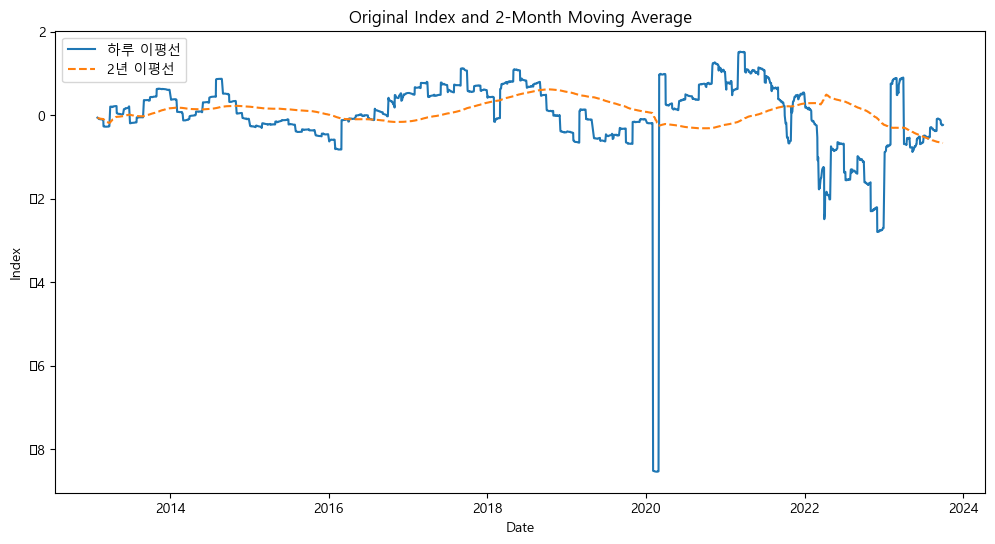

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(df_index['index_moving_short_avg'], label='하루 이평선')
plt.plot(df_index['index_moving_long_avg'], label='2년 이평선', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Original Index and 2-Month Moving Average')
plt.legend()
plt.show()

In [84]:
df_index['signal'] = np.where(df_index['index_moving_short_avg'] > df_index['index_moving_long_avg'], 1.0, 0.0) # 1.0이 매수를 의미함
buy_count = df_index[df_index['signal'] == 1.0].shape[0]
print("Signal 값이 1.0인 행의 개수는 {}개 입니다.".format(buy_count))

sell_count = df_index[df_index['signal'] == 0.0].shape[0]
print("Signal 값이 0.0인 행의 개수는 {}개 입니다.".format(sell_count))

Signal 값이 1.0인 행의 개수는 1329개 입니다.
Signal 값이 0.0인 행의 개수는 1205개 입니다.


In [23]:
df_index['Close'] = df_close

In [24]:
#df_index.dropna(inplace = True)

In [25]:
# 매수/매도에 따른 자산 변화를 저장할 리스트
asset_diff_list = []

# 매수 상태를 나타내는 변수 (매수하면 True, 매도하면 False)
buy_flag = False

# 매수한 가격을 저장하는 변수
buy_price = 0

# 데이터프레임의 각 행을 순회하면서 매수/매도 신호에 따라 작업을 수행
for i, row in df_index.iterrows():
    # 매수 신호가 나왔고, 아직 매수하지 않은 상태라면 매수를 진행
    if row['signal'] == 1.0 and not buy_flag:
        buy_flag = True
        buy_price = row['Close']
        asset_diff_list.append(0)  # 매수 직후에는 변화 없음

    # 매도 신호가 나왔고, 매수한 상태라면 매도를 진행
    elif row['signal'] == 0.0 and buy_flag:
        buy_flag = False
        # 매도 종가 - 매수 종가로 가격 차이를 계산
        price_diff = row['Close'] - buy_price
        asset_diff_list.append(price_diff)

    # 매수 상태면서 매도 신호가 아직 오지 않았다면, 가격 변화를 계산해서 추가
    elif buy_flag and row['signal'] != 0.0:
        price_diff = row['Close'] - buy_price
        asset_diff_list.append(price_diff)

    # 매수 상태가 아니라면 가격 변화가 없으므로 이전 값을 그대로 사용
    else:
        asset_diff_list.append(asset_diff_list[-1] if asset_diff_list else 0)  # 첫 행의 경우 asset_diff_list가 비어있으므로 0을 사용

# 가격 변화를 데이터프레임에 추가
df_index['asset_diff'] = asset_diff_list


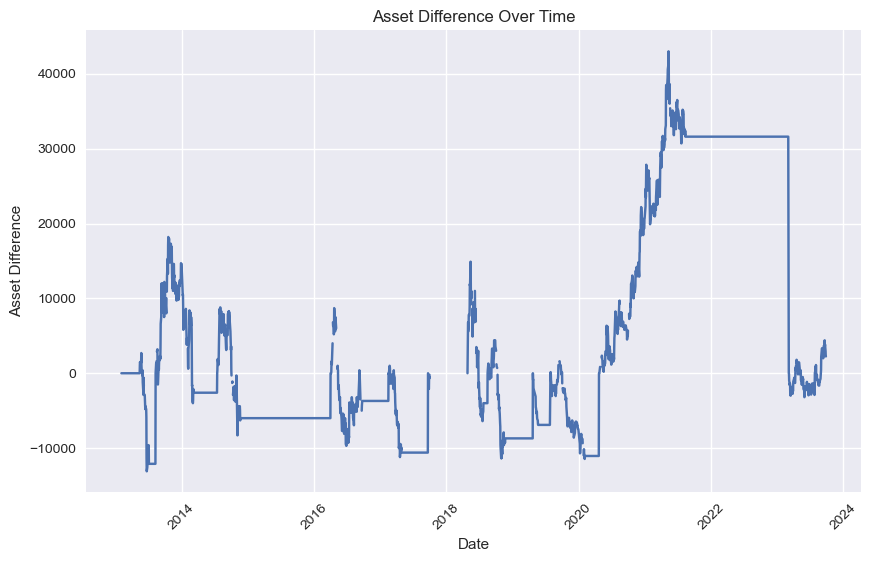

In [26]:
import matplotlib.pyplot as plt

# matplotlib의 스타일을 설정
plt.style.use('seaborn')

# 그래프를 그릴 데이터를 설정 (x축: 날짜, y축: asset_diff)

# 그래프를 그림
plt.figure(figsize=(10, 6))  # 그래프의 크기를 설정
plt.plot(df_index['asset_diff'])  # 꺾은선 그래프를 그림, 각 점에 마커를 표시
plt.title('Asset Difference Over Time')  # 그래프의 제목을 설정
plt.xlabel('Date')  # x축의 라벨을 설정
plt.ylabel('Asset Difference')  # y축의 라벨을 설정
plt.xticks(rotation=45)  # x축의 라벨을 45도 회전
plt.grid(True)  # 그리드를 표시

# 그래프를 화면에 표시
